# Star Tracker Astrometry Pipeline  
### Digantara – Image Processing Engineer (Star Tracker) Assessment

This notebook demonstrates a complete star matching and astrometry pipeline
developed for ground-based SSA imagery using GAIA DR3 catalog data.


In [23]:
!pip install astroquery astropy


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astroquery.gaia import Gaia
from scipy.spatial import KDTree



In [25]:
# ---- Metadata (star_centroids_2) ----
IMAGE_WIDTH  = 1024
IMAGE_HEIGHT = 1024

FOCAL_LENGTH_MM = 4912
PIXEL_PITCH_UM  = 3.6

RA0_DEG  = 101.812
DEC0_DEG = -48.565

FOV_X_DEG = 0.429
FOV_Y_DEG = 0.429

MAG_LIMIT = 11.5   # relaxed for sparse field



A1: Query GAIA

In [26]:
query = f"""
SELECT ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE
  CONTAINS(
    POINT('ICRS', ra, dec),
    BOX('ICRS', {RA0_DEG}, {DEC0_DEG}, {FOV_X_DEG}, {FOV_Y_DEG})
  ) = 1
AND phot_g_mean_mag < {MAG_LIMIT}
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_df = job.get_results().to_pandas()

print("Number of GAIA stars:", len(gaia_df))
gaia_df


Number of GAIA stars: 10


,ra,dec,phot_g_mean_mag
0,101.844742,-48.563410,6.680928
1,101.765584,-48.532563,9.106405
2,101.639432,-48.684723,9.733986
3,101.723583,-48.405392,10.392154
4,101.844634,-48.563895,10.418353
5,101.751143,-48.585390,10.626469
6,101.656004,-48.372222,10.833928
7,101.640368,-48.758371,11.105173
8,101.619392,-48.490669,11.362129
9,101.850929,-48.576735,11.392465


A1: Catalog plots

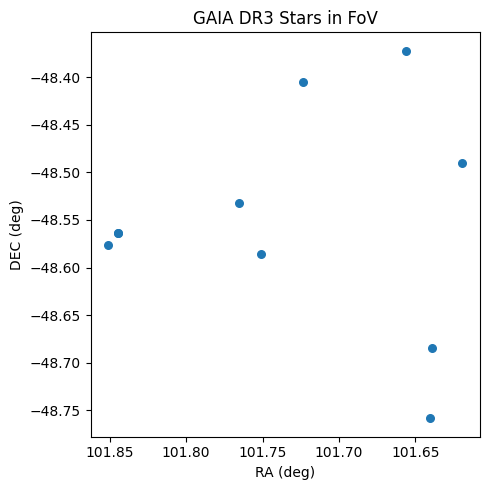

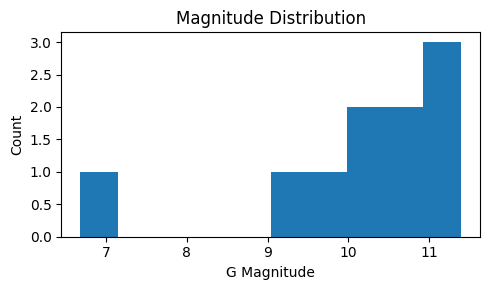

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(gaia_df["ra"], gaia_df["dec"], s=30)
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("GAIA DR3 Stars in FoV")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.hist(gaia_df["phot_g_mean_mag"], bins=10)
plt.xlabel("G Magnitude")
plt.ylabel("Count")
plt.title("Magnitude Distribution")
plt.tight_layout()
plt.show()


A2: Unit vectors & angular distances

In [28]:
ra_rad  = np.deg2rad(gaia_df["ra"].values)
dec_rad = np.deg2rad(gaia_df["dec"].values)

vec_cat = np.vstack([
    np.cos(dec_rad) * np.cos(ra_rad),
    np.cos(dec_rad) * np.sin(ra_rad),
    np.sin(dec_rad)
]).T

ang_cat = np.arccos(np.clip(vec_cat @ vec_cat.T, -1, 1))
print("Catalog stars:", vec_cat.shape[0])


Catalog stars: 10


A2: Angular features (sparse-safe)

In [29]:
def angular_features(ang_mat, k=3):
    feats, idxs = [], []
    for i in range(len(ang_mat)):
        d = np.sort(ang_mat[i][ang_mat[i] > 0])
        if len(d) >= k:
            feats.append(d[:k])
            idxs.append(i)
    return np.array(feats), np.array(idxs)

feat_cat, cat_idx = angular_features(ang_cat, k=3)
print("Catalog features shape:", feat_cat.shape)


Catalog features shape: (10, 3)


In [30]:
gaia_df.to_csv("gaia_catalog_star_centroids_2.csv", index=False)


In [10]:
from google.colab import files
files.download("gaia_catalog_star_centroids_2.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from google.colab import files
uploaded = files.upload()


Saving star_centroids_2.csv to star_centroids_2.csv


Load & preprocess centroids

In [31]:
df = pd.read_csv("star_centroids_2.csv")
df = df.sort_values("brightness", ascending=False).iloc[:25].reset_index(drop=True)

cx, cy = IMAGE_WIDTH/2, IMAGE_HEIGHT/2
f_pix = (FOCAL_LENGTH_MM * 1e3) / PIXEL_PITCH_UM

dx = df["x_centroid"].values - cx
dy = df["y_centroid"].values - cy

vec_img = np.vstack([dx, dy, np.ones_like(dx)*f_pix]).T
vec_img /= np.linalg.norm(vec_img, axis=1)[:, None]

ang_img = np.arccos(np.clip(vec_img @ vec_img.T, -1, 1))


A3 :Image angular features

In [32]:
feat_img, img_idx = angular_features(ang_img, k=3)
print("Image features shape:", feat_img.shape)


Image features shape: (25, 3)


One-to-one feature matching

In [33]:
tree = KDTree(feat_cat)

used_catalog = set()
matches = []

for i, f in enumerate(feat_img):
    dist, j = tree.query(f, distance_upper_bound=0.03)

    if not np.isfinite(dist):
        continue

    if j in used_catalog:
        continue

    used_catalog.add(j)
    matches.append((img_idx[i], cat_idx[j]))

print("Initial unique matches:", len(matches))
matches


Initial unique matches: 2


[(np.int64(0), np.int64(0)), (np.int64(2), np.int64(9))]

Solve rotation & residuals

In [34]:
img_indices = [m[0] for m in matches]
cat_indices = [m[1] for m in matches]

V_img = vec_img[img_indices]
V_cat = vec_cat[cat_indices]

def solve_rotation(A, B):
    H = B.T @ A
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1] *= -1
        R = Vt.T @ U.T
    return R

R = solve_rotation(V_img, V_cat)
V_rot = (R @ V_cat.T).T

res = np.arccos(np.clip(np.sum(V_img * V_rot, axis=1), -1, 1))
res_arcsec = res * 180/np.pi * 3600

print("RMS angular error (arcsec):", np.sqrt(np.mean(res_arcsec**2)))


RMS angular error (arcsec): 7.3288620651283525


Residual Plots

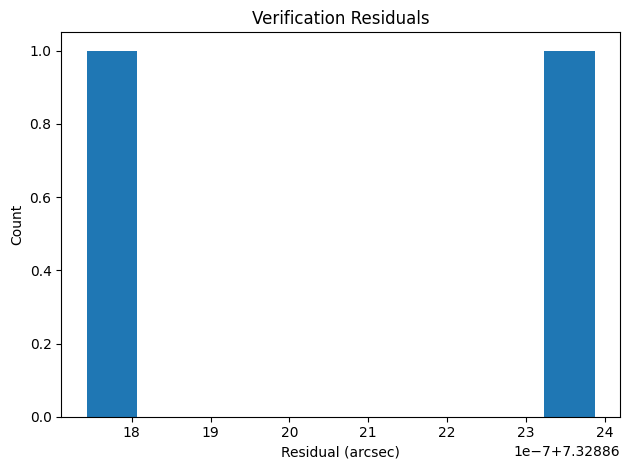

In [35]:
plt.hist(res_arcsec, bins=10)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Count")
plt.title("Verification Residuals")
plt.tight_layout()
plt.show()


A5: Final Matched Star Output

In [20]:
matched_df = pd.DataFrame({
    "x_centroid": df.loc[img_indices, "x_centroid"].values,
    "y_centroid": df.loc[img_indices, "y_centroid"].values,
    "brightness": df.loc[img_indices, "brightness"].values,
    "ra": gaia_df.loc[cat_indices, "ra"].values,
    "dec": gaia_df.loc[cat_indices, "dec"].values,
    "magnitude": gaia_df.loc[cat_indices, "phot_g_mean_mag"].values
})

matched_df


,x_centroid,y_centroid,brightness,ra,dec,magnitude
0,671.690809,557.623244,1550087,101.844742,-48.563410,6.680928
1,358.470942,264.613470,1213622,101.850929,-48.576735,11.392465


In [21]:
matched_df.to_csv("matched_star_data_star_centroids_2.csv", index=False)

from google.colab import files
files.download("matched_star_data_star_centroids_2.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>